# Medical Appointment No-Shows Analysis


## Introduction

In this notebook we will explore a dataset containing aproximately 100k medical appointments from the Brazilian public health system. One of the largest health system of the world.

> This is at municipal level combining the appointments occured in more then 45 units. As fasr as we know, the city has 20 million loss a year with no-shows. After so many studies happening in this data the average no-show now is 20\%. It is important to mention that all services offered to the municipality were free of charge.

This analysis is focused on the question of whether or not patients show up for their appointment, including a set of characterisitics about the patient in each row:

* `ScheduledDay`: tells us on which day the patient set up their appointment.
* `Neighborhood`: indicates the location of the hopital.
* `Scholarhip`: indicates whether or not the patient is enrolled in Brasilian welfare program called *Bolsa familia*
* `No-show`: it says `No` if the patient showed up to their appointment, and `Yes` if they didn't show up.

This analysis aims to outline some possible reasons for patient no-showing at the scheduled appointments, as well as get insights about the Brazilian public health system.

### Initial Statements

This section sets up import statements for all packages that will be used throught this python notebook.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

In [2]:
# set notebook environment
%matplotlib inline

sns.set_style('white')

%precision %.3f
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = 10,8
pd.set_option('display.width', 100)
plt.rcParams.update({'font.size': 22})

# Disable jedi autocompleter
%config Completer.use_jedi = False

In [3]:
df = pd.read_csv('../Datasets/KaggleV2-May-2016.csv.zip')

In [4]:
df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
65564,"26,792,229,216,869.00",5678476,F,2016-05-10T08:32:36Z,2016-05-10T00:00:00Z,57,TABUAZEIRO,0,1,0,0,0,0,No
81123,"85,248,561,575,784.00",5739331,F,2016-05-25T13:18:58Z,2016-05-25T00:00:00Z,50,BONFIM,0,1,0,0,0,0,No
51603,"8,572,928,812.00",5742544,M,2016-05-30T08:06:26Z,2016-05-30T00:00:00Z,12,PIEDADE,0,0,0,0,0,0,No
91051,"7,583,317,873,324.00",5628149,M,2016-04-27T10:33:39Z,2016-06-03T00:00:00Z,13,CARATOÍRA,0,0,0,0,0,0,No
63484,"9,762,241,884,231.00",5640660,F,2016-04-29T11:09:31Z,2016-05-30T00:00:00Z,3,ANDORINHAS,0,0,0,0,0,0,Yes


### Getting to Know The Data

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 44.3 MB


In [6]:
print ("Rows     : " , df.shape[0])
print ("\nUnique values :  \n",df.nunique())

Rows     :  110527

Unique values :  
 PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


## Data Wrangling

### Update Data Types
Let's clean our dataset a bit.
We start by transforming the data the right format. It allows us to save some memory and simplifies further processing.

In [7]:
# Update neighborhood, Gender and No-show data types
# From object to category
df['Neighbourhood'] = df['Neighbourhood'].astype('category')
df['Gender'] = df['Gender'].astype('category')

# Convert Paient ID data type from float to int
df['PatientId'] = df['PatientId'].astype(int)

# Replace Yes/No with True/False
df['No-show'].replace({'No': False, 'Yes': True}, inplace=True)

In [8]:
df[['ScheduledDay']].head(3)

,ScheduledDay
0,2016-04-29T18:38:08Z
1,2016-04-29T16:08:27Z
2,2016-04-29T16:19:04Z


While the scheduling date is recorded to the second, the time of the appointment is missing. Schade!
I would like to add two more columns to the dataset: number of waiting days as well as the appointment as day of the week. But before let's change the data type of the scheduling day and remove the time from it.

In [9]:
# From object to datetime
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'].str.split('T').str[0])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'].str.split('T').str[0])

### Add, Remove and Update  Features

Now that we have converted the dates to the correct data type format: `Timestamps` , we can compute the waiting days till appointment by a simple substraction:

In [10]:
df['WaitingDays'] = df['AppointmentDay'] - df['ScheduledDay']

# Transform the waiting days to int
df['WaitingDays'] = df['WaitingDays'].dt.days

Remove appointment IDs, they don't contain any valuable information. We could also remove patient ID's, however I want to check if some patients didn't show more than twice. We will also remove the 'ScheduledDay' variable

In [11]:
# remove  'AppointmentID' & 'ScheduledDay'
df.drop(['AppointmentID', 'ScheduledDay'], axis=1, inplace=True);

In [12]:
# Rename columns
df.rename(columns={'Neighbourhood': 'Neighborhood',
                   'Handcap': 'Handicap',
                   'Hipertension': 'Hypertension'},
          inplace=True)

In [13]:
 df['AppointmentDay'].dt.day_name().astype('category').unique()

['Friday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday', 'Saturday']
Categories (6, object): ['Friday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday', 'Saturday']

In [14]:
# change upper case to title case inside Neighborhood
df['Neighborhood'] = df['Neighborhood'].str.title().astype('category')
df['Neighborhood'][0]

'Jardim Da Penha'

In [15]:
# Extract Day of the week and Month from appointments
df['AppointmentMonth'] = df['AppointmentDay'].dt.month_name().astype('category')
df['AppointmentDay'] = df['AppointmentDay'].dt.day_name().astype('category')

### Data Consistency Check

In [16]:
# Let's check the consistency of the results
df[df['WaitingDays'] < 0]

,PatientId,Gender,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,WaitingDays,AppointmentMonth
27033,7839272661752,M,Monday,38,Resistência,0,0,0,0,1,0,True,-1,May
55226,7896293967868,F,Tuesday,19,Santo Antônio,0,0,0,0,1,0,True,-1,May
64175,24252258389979,F,Wednesday,22,Consolação,0,0,0,0,0,0,True,-1,May
71533,998231581612122,F,Thursday,81,Santo Antônio,0,0,0,0,0,0,True,-6,May
72362,3787481966821,M,Tuesday,7,Tabuazeiro,0,0,0,0,0,0,True,-1,May


In [17]:
# remove negative waiting days
df = df[df['WaitingDays'] >= 0]

Check age consistency

In [18]:
len(df[df['Age'] < 0])

1

In [19]:
# Remove non consistent ages
df = df[df['Age'] >= 0]
df.reindex();

### Memory Optimization

In [20]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   PatientId         110521 non-null  int64   
 1   Gender            110521 non-null  category
 2   AppointmentDay    110521 non-null  category
 3   Age               110521 non-null  int64   
 4   Neighborhood      110521 non-null  category
 5   Scholarship       110521 non-null  int64   
 6   Hypertension      110521 non-null  int64   
 7   Diabetes          110521 non-null  int64   
 8   Alcoholism        110521 non-null  int64   
 9   Handicap          110521 non-null  int64   
 10  SMS_received      110521 non-null  int64   
 11  No-show           110521 non-null  bool    
 12  WaitingDays       110521 non-null  int64   
 13  AppointmentMonth  110521 non-null  category
dtypes: bool(1), category(4), int64(9)
memory usage: 9.0 MB


As we can see, just by updating the variables data types we drastically reduced the memory usage; from 44 MB to 9 MB. We could much better: many features can be converted to boolean and age and waiting days to int8. It depends on the available RAM and the size of the dataset, for me 9 MB are fine.

## Exploratory Data Analysis

Once the data has been cleaned and trimmed, we can move on to explore it. I, usually start by looking at each variable independently and try to find interesting behaviour to further investigate. Thus, the most interesting hypotheses to explore are posed at this stage of the analysis.

### Neighborhood Analysis

We will explore the no-showing appointments relative to neighborhoods. We start by plotting the distribution of appointments per neighborhood.

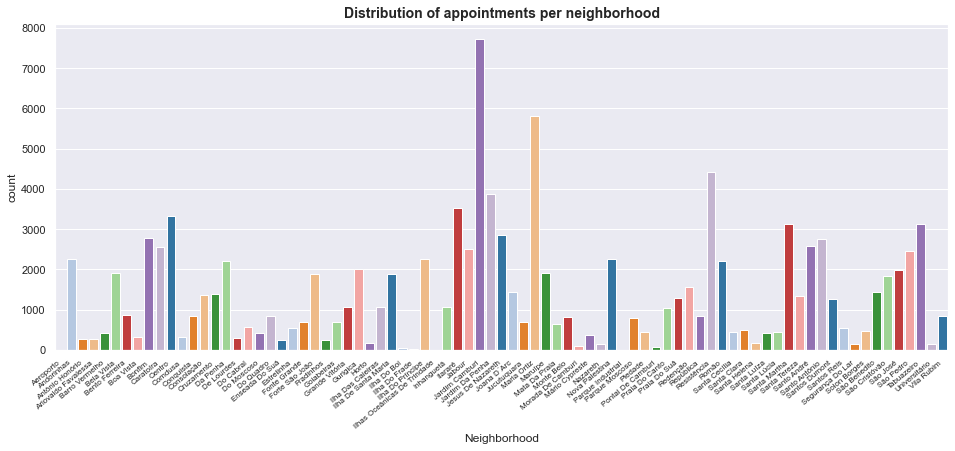

In [21]:
col_pal = sns.color_palette("tab20", n_colors=10)
sns.set(style='darkgrid', context='notebook', rc={"figure.figsize": (16, 6)})
g = sns.countplot(data=df, x='Neighborhood', palette=col_pal)
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of appointments per neighborhood', fontsize=14, fontweight='bold');

Some of the neighborhoods have substantially less appointments than others. So, it's interesting to further investigate this matter. Let's first start by plotting the No-showing rate by neighborhood.

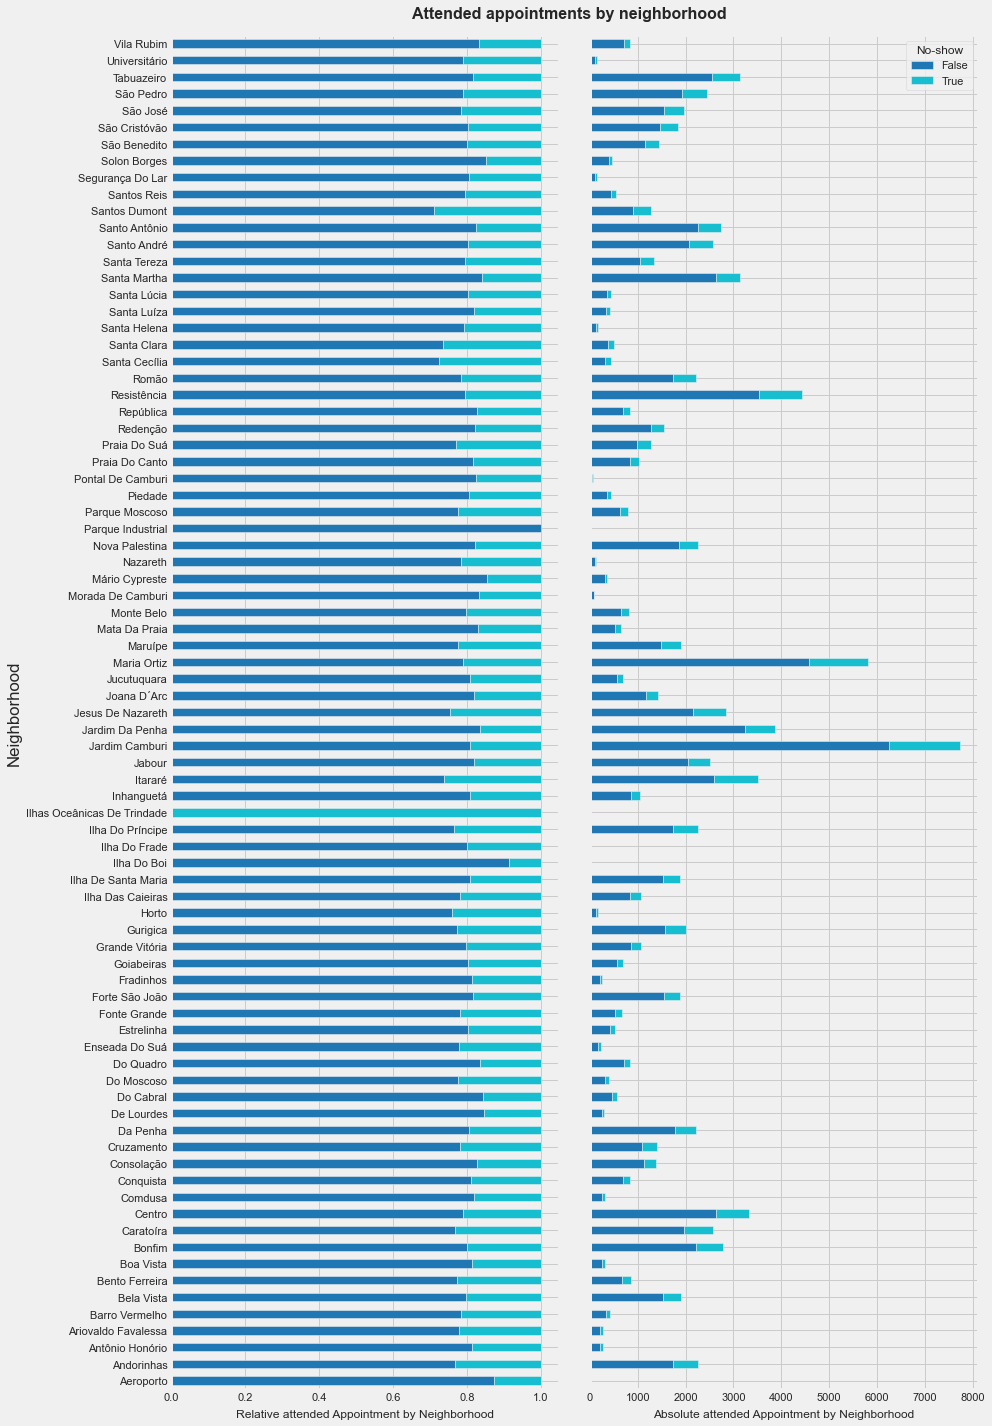

In [159]:
## Initialize the matplotlib figure:
fig, axs = plt.subplots(1,2, figsize=(12, 20), sharey=True)
fig.tight_layout() 
fig.subplots_adjust(top=.96)  #Adjusting the space for the superior title

pd.crosstab(df['Neighborhood'], 
            df['No-show'], normalize='index').plot.barh(align='center', 
                                                        cmap='tab10',
                                                        stacked=True, ax=axs[0])
axs[0].get_legend().remove()
axs[0].set_title('Relative attended Appointment by Neighborhood', fontsize=12, y=-.025)

pd.crosstab(df['Neighborhood'], df['No-show']).plot.barh(align='center', stacked=True, 
                                                         cmap='tab10',ax=axs[1])

axs[1].set_title('Absolute attended Appointment by Neighborhood', fontsize=12, y=-.025)

plt.suptitle('Attended appointments by neighborhood', fontsize=16, fontweight='bold');

From this plot we see 2 extreme cases. One with 100% No-show rate and other with 0% No-show rate. However, they are statistically irrelevant, since they represent one appointment each.

<div class="alert alert-block alert-warning">
<b>1st Hypothesis:</b> <br> 
   Number of appointments per Neighborhood doesn't affect the No-show probability.
</div>

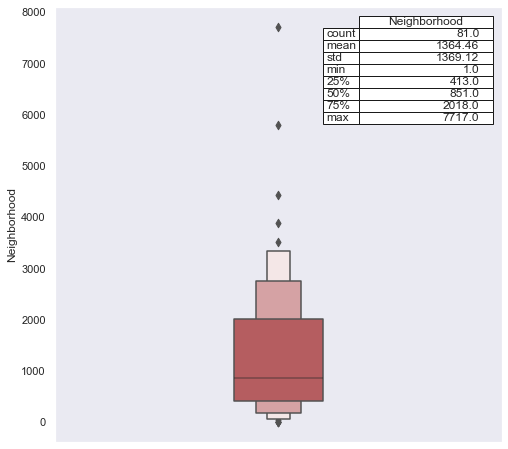

In [22]:
# 5 number summary of the number of appointments
sns.set(style='dark', rc={"figure.figsize": (8, 8)})
g=sns.boxenplot(y=df['Neighborhood'].value_counts(), color='r', width=.2);
pd.plotting.table(g, np.round(df['Neighborhood'].value_counts().describe(), 2), 
                  loc='upper right', colWidths=[.3, 1]);

In [29]:
# We create 11 Neighborhood categories based on their number of appointments 
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (14, 8)
arr = df['Neighborhood'].value_counts()
intervals = pd.cut(arr, 15, right=False)
df['NeighbourGroups'] = df['Neighborhood'].replace(dict(intervals))

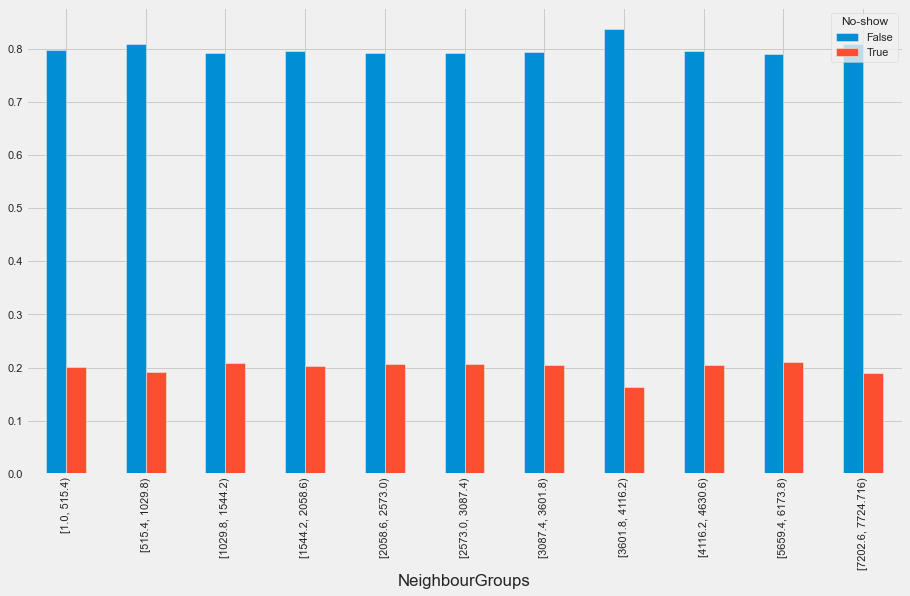

In [171]:
df.groupby('NeighbourGroups')['No-show'].value_counts(normalize=True).unstack().plot.bar();

As we can see from above, there is no correlation between patients showing to an appointment and number of appointment per neighborhood. So the first hypothesis is true. 

In [172]:
df.groupby('NeighbourGroups')['No-show'].value_counts(normalize=True).unstack()

No-show,False,True
NeighbourGroups,,
"[1.0, 515.4)",0.80,0.20
"[515.4, 1029.8)",0.81,0.19
"[1029.8, 1544.2)",0.79,0.21
"[1544.2, 2058.6)",0.80,0.20
"[2058.6, 2573.0)",0.79,0.21
"[2573.0, 3087.4)",0.79,0.21
"[3087.4, 3601.8)",0.79,0.21
"[3601.8, 4116.2)",0.84,0.16
"[4116.2, 4630.6)",0.80,0.20


In [173]:
arr[arr.between(3601.8, 4116.2)]

Jardim Da Penha    3877
Name: Neighborhood, dtype: int64

In [268]:
arr

WaitingDays,0,1,2,3,4,5,6,7,8,9,...,133,139,142,146,151,155,162,169,176,179
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Aeroporto,3,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorinhas,738,111,106,67,99,75,84,159,77,34,...,0,0,0,0,0,0,0,0,0,0
Antônio Honório,91,6,10,3,6,3,10,3,2,3,...,0,0,0,0,0,0,0,0,0,0
Ariovaldo Favalessa,107,26,21,7,15,8,7,5,5,2,...,0,0,0,0,0,0,0,0,0,0
Barro Vermelho,138,17,26,14,20,9,16,20,4,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
São José,601,109,124,55,125,116,171,119,91,32,...,0,0,0,0,0,0,0,0,0,0
São Pedro,864,177,149,126,175,108,133,182,74,30,...,0,0,0,0,0,0,0,0,0,0
Tabuazeiro,1207,117,151,68,133,82,91,114,61,50,...,0,0,0,0,0,1,1,0,1,0


However, the group with  number of appointments between 3601 and 4116, which consists actually in one health unit, is doing better than all other groups. We will investigate this health unit further.

### Waiting Days Analysis

<div class="alert alert-block alert-warning">
<b>2nd Hypothesis:</b> <br>
    There is no correlation between total number of appointments per Neighborhood and waiting days till appointment.
</div>

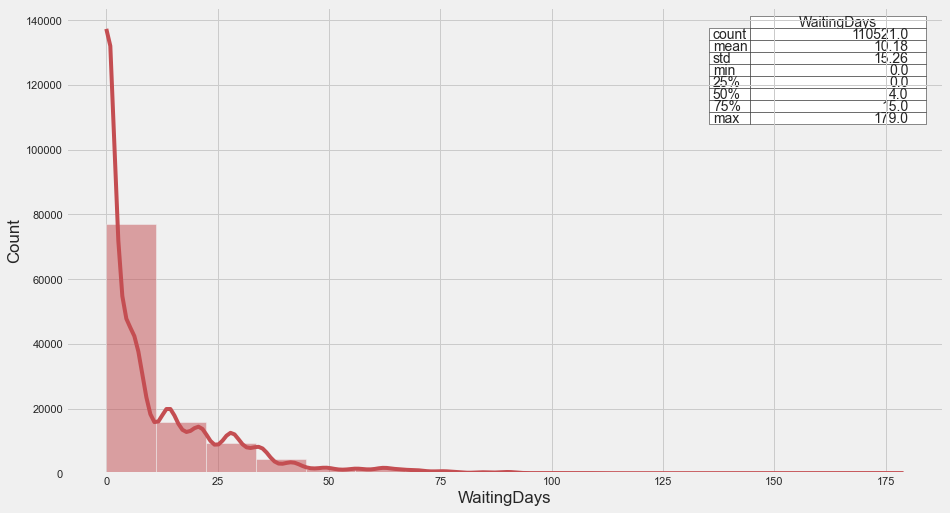

In [32]:
g = sns.histplot(data=df, x='WaitingDays',kde=True, color='r', bins=16)
pd.plotting.table(g, np.round(df['WaitingDays'].describe(), 2), 
                  loc='upper right', colWidths=[.2, .2, .3, .3]);

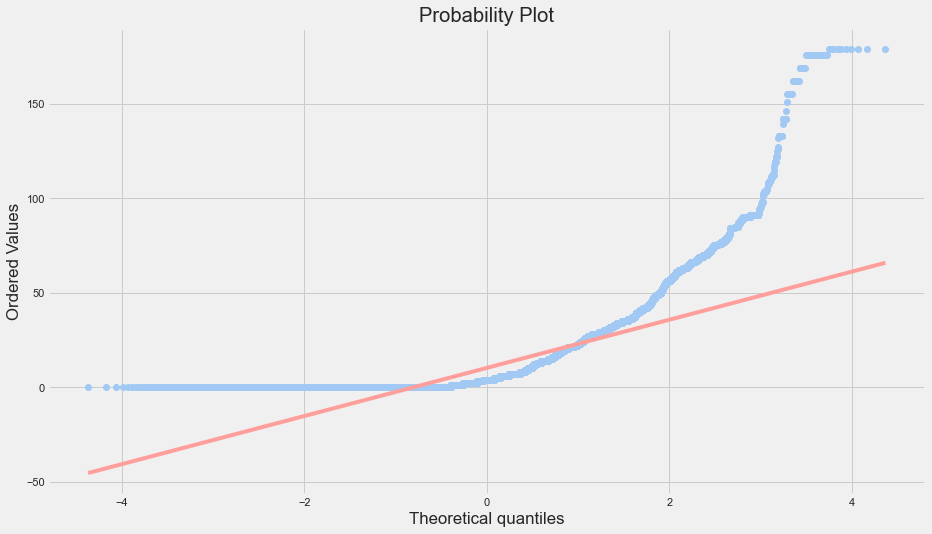

In [243]:
import scipy.stats as stats

stats.probplot(df['WaitingDays'], dist='norm', plot=plt);

The average waiting is about 10 days, with a standard deviation of approximately 15 days and maximum of 179 days. The qqplot suggests that the data right skewed with a long tail.

The days that a patient has to wait for a consultation varies from 0 to 175 days. For a better overview and analysis we will group the WaitingsDays into categories or bins.

In [263]:
categories = pd.Series(['0', '1-3', '4-7', '8-15', 
                        '16-30', '31-90', '91-180'])
df['WaitingPeriods'] = pd.cut(df['WaitingDays'], bins=[-1, 0, 3, 7, 15, 30, 90, 180], labels=categories)

In [267]:
pd.crosstab(df['WaitingPeriods'], df['NeighbourGroups'] )

NeighbourGroups,"[1.0, 515.4)","[515.4, 1029.8)","[1029.8, 1544.2)","[1544.2, 2058.6)","[2058.6, 2573.0)","[2573.0, 3087.4)","[3087.4, 3601.8)","[3601.8, 4116.2)","[4116.2, 4630.6)","[5659.4, 6173.8)","[7202.6, 7724.716)"
WaitingPeriods,,,,,,,,,,,
0,2129,3132,4740,5232,7743,3286,4887,1222,1612,2075,2504
1-3,951,1496,1910,2072,2886,1103,1503,464,448,560,1282
4-7,1102,1764,2280,2761,4006,1163,1673,459,758,582,962
8-15,943,1466,1904,2057,3090,798,1555,394,411,375,535
16-30,1316,1470,1943,1681,2534,1471,2399,1299,457,862,436
31-90,460,895,976,1080,1041,543,1082,33,727,1348,1976
91-180,26,10,16,84,16,6,11,6,17,3,22


Here, it is important to differentiate between two group of patients: the under 16 and over 16. Since the former don't enjoy a doctor-patient confidentiality yet and usually they must bring one of their parent for a consultation. So including their data in the overall probability analysis doesn't make really sense. They usually don't show because of their parents and not because of a handicap or something else.

In [26]:
df['No-show'].value_counts(normalize=True)

False   0.80
True    0.20
Name: No-show, dtype: float64

In [64]:
df[df['Age']>15]['No-show'].value_counts(normalize=True)

False   0.80
True    0.20
Name: No-show, dtype: float64

In [65]:
df[df['Age']<16]['No-show'].value_counts(normalize=True)

False   0.79
True    0.21
Name: No-show, dtype: float64

Interesting! I didn't expect both groups to be almost equal.  
So to make further analysis easier we are going to create age groups

In [ ]:
cut_labels = ['Babies', 'Children', 'Young', 'Middle-aged']

In [219]:
df['Neighborhood'].value_counts().describe()

count      81.00
mean    1,364.46
std     1,369.12
min         1.00
25%       413.00
50%       851.00
75%     2,018.00
max     7,717.00
Name: Neighborhood, dtype: float64

### Analyzing the Probability of Showing Up with Respect to Different Features
